<a href="https://colab.research.google.com/github/Onethybeing/tom_jeery_predictor_using_pytorch/blob/main/Tom_jeery_predictor_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
# Upload your Kaggle API token to your google drive as json file and then change the path in the below line before running.
!cp /content/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download balabaskar/tom-and-jerry-image-classification
! unzip tom-and-jerry-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2793.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2794.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2795.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2796.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2797.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2798.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2799.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2800.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2801.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2802.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2803.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2804.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2805.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2806.jpg  
  inflating: tom_and_jerry/tom_and_jerry/jerry/frame2807.jpg  
  in

In [5]:
import pandas as pd
import zipfile
import os

# 1. Unzip the dataset (only if not already extracted)
zip_path = "/content/tom-and-jerry-image-classification.zip"
extract_path = "/content"

if not os.path.exists(os.path.join(extract_path, "tom_and_jerry")):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# 2. Load CSV files
ground_truth_path = os.path.join(extract_path, "ground_truth.csv")
challenges_path = os.path.join(extract_path, "challenges.csv")

ground_truth_df = pd.read_csv(ground_truth_path)
challenges_df = pd.read_csv(challenges_path)

# 3. Show first few rows
print("Ground Truth:")
print(ground_truth_df.head())

print("\nChallenges:")
print(challenges_df.head())


Ground Truth:
     filename  tom  jerry
0  frame0.jpg    0      0
1  frame1.jpg    0      0
2  frame2.jpg    0      0
3  frame3.jpg    0      0
4  frame4.jpg    0      0

Challenges:
  folder     image_name
0  jerry   frame360.jpg
1  jerry  frame1794.jpg
2  jerry  frame1795.jpg
3  jerry  frame2231.jpg
4  jerry  frame2234.jpg


In [23]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import warnings
import kagglehub

In [26]:
path="/content/tom_and_jerry/tom_and_jerry"
os.listdir("/content/tom_and_jerry/tom_and_jerry")

['tom_jerry_1', 'jerry', 'tom_jerry_0', 'tom']

In [27]:
labels={ k:val for k,val in enumerate(os.listdir(path))}
labels_rev={ val:k for k,val in enumerate(os.listdir(path))}
print(labels)
print(labels_rev)

{0: 'tom_jerry_1', 1: 'jerry', 2: 'tom_jerry_0', 3: 'tom'}
{'tom_jerry_1': 0, 'jerry': 1, 'tom_jerry_0': 2, 'tom': 3}


In [28]:
import random

image_files = [f"{path}/{valu}/{f}" for valu in labels.values() for f in os.listdir(f"{path}/{valu}/")]
Images_Random = random.sample(image_files, 10)
Images_Random

['/content/tom_and_jerry/tom_and_jerry/tom/frame4140.jpg',
 '/content/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame4049.jpg',
 '/content/tom_and_jerry/tom_and_jerry/jerry/frame1645.jpg',
 '/content/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame3158.jpg',
 '/content/tom_and_jerry/tom_and_jerry/jerry/frame5246.jpg',
 '/content/tom_and_jerry/tom_and_jerry/jerry/frame3877.jpg',
 '/content/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame528.jpg',
 '/content/tom_and_jerry/tom_and_jerry/tom_jerry_0/frame2724.jpg',
 '/content/tom_and_jerry/tom_and_jerry/jerry/frame3332.jpg',
 '/content/tom_and_jerry/tom_and_jerry/tom/frame3814.jpg']

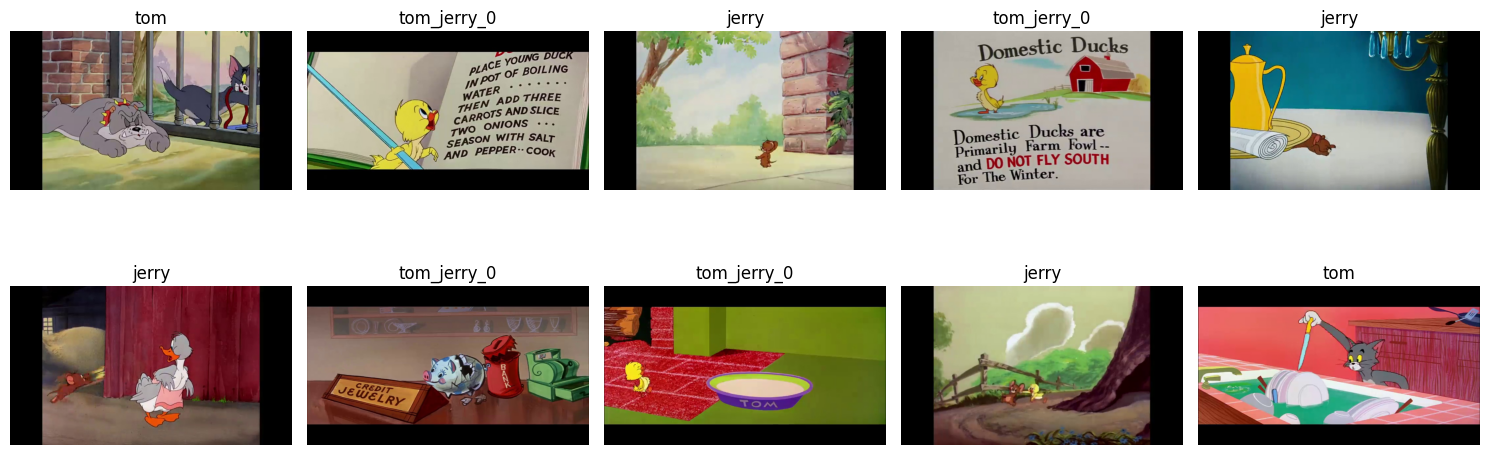

In [30]:
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # flatten to easily iterate

for i in range(len(Images_Random)):
    image = Image.open(Images_Random[i])
    axes[i].imshow(image)
    axes[i].axis('off')
    #print(image.size)


    label=Images_Random[i].split('/')[-2]
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

In [31]:
class tom_jerry_Dataset(Dataset):
    def __init__(self, root_dir, labels=labels,transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels_name=labels
        self.image_paths=[]
        self.labels=[]
        for label, folder in self.labels_name.items():
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                    self.image_paths.append(os.path.join(folder_path, fname))
                    self.labels.append(float(label))


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            return image,label

In [32]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),# Resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], #Normalize using ImageNet mean
                          std=[0.229, 0.224, 0.225]) #Normalize using ImageNet std
])

dataset = tom_jerry_Dataset(path, transform=transform)

In [33]:
len(dataset)

5478

In [34]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
random_seed = 42

dataset_size = len(dataset)
indices = list(range(dataset_size))

train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=random_seed)

train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, val_indices)

In [35]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

In [36]:
# Check a batch of images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([3., 3., 1., 0., 1., 3., 3., 2., 3., 3., 3., 1., 2., 2., 2., 3., 0., 3.,
        3., 2., 2., 2., 2., 3., 1., 2., 3., 3., 2., 0., 0., 1.],
       dtype=torch.float64)


In [37]:
from torchvision import models

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features,4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 99.8MB/s]


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [39]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images,labels= images.to(device), labels.to(device)
        labels=labels.long()


        outputs = model(images).squeeze()

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)


        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels=labels.long()


            outputs = model(images).squeeze()# The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)


    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)
        # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")

100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch 1/10: Train Loss=0.4415, Train Accuracy=84.80%, Val Loss=0.2455, Val Accuracy=92.70%


100%|██████████| 137/137 [00:33<00:00,  4.04it/s]


Epoch 2/10: Train Loss=0.1731, Train Accuracy=94.98%, Val Loss=0.1801, Val Accuracy=94.62%


100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Epoch 3/10: Train Loss=0.1205, Train Accuracy=95.94%, Val Loss=0.2397, Val Accuracy=94.43%


100%|██████████| 137/137 [00:37<00:00,  3.69it/s]


Epoch 4/10: Train Loss=0.1239, Train Accuracy=95.82%, Val Loss=0.1908, Val Accuracy=94.89%


100%|██████████| 137/137 [00:33<00:00,  4.14it/s]


Epoch 5/10: Train Loss=0.0851, Train Accuracy=97.51%, Val Loss=0.1724, Val Accuracy=95.07%


100%|██████████| 137/137 [00:35<00:00,  3.89it/s]


Epoch 6/10: Train Loss=0.0543, Train Accuracy=98.24%, Val Loss=0.1680, Val Accuracy=95.80%


100%|██████████| 137/137 [00:33<00:00,  4.05it/s]


Epoch 7/10: Train Loss=0.0536, Train Accuracy=98.15%, Val Loss=0.1532, Val Accuracy=96.35%


100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch 8/10: Train Loss=0.0604, Train Accuracy=97.85%, Val Loss=0.1878, Val Accuracy=95.99%


100%|██████████| 137/137 [00:33<00:00,  4.09it/s]


Epoch 9/10: Train Loss=0.0370, Train Accuracy=98.79%, Val Loss=0.1532, Val Accuracy=96.26%


100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


Epoch 10/10: Train Loss=0.0655, Train Accuracy=97.85%, Val Loss=0.1692, Val Accuracy=95.89%


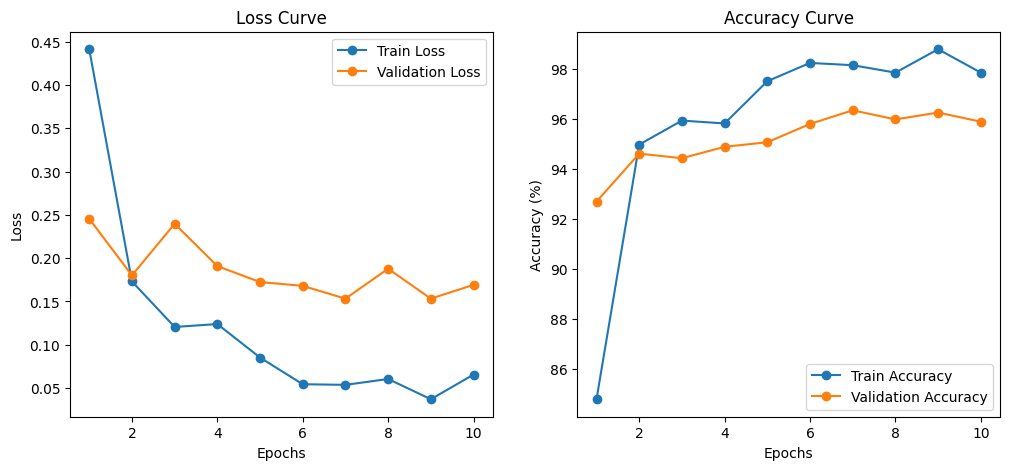

In [41]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

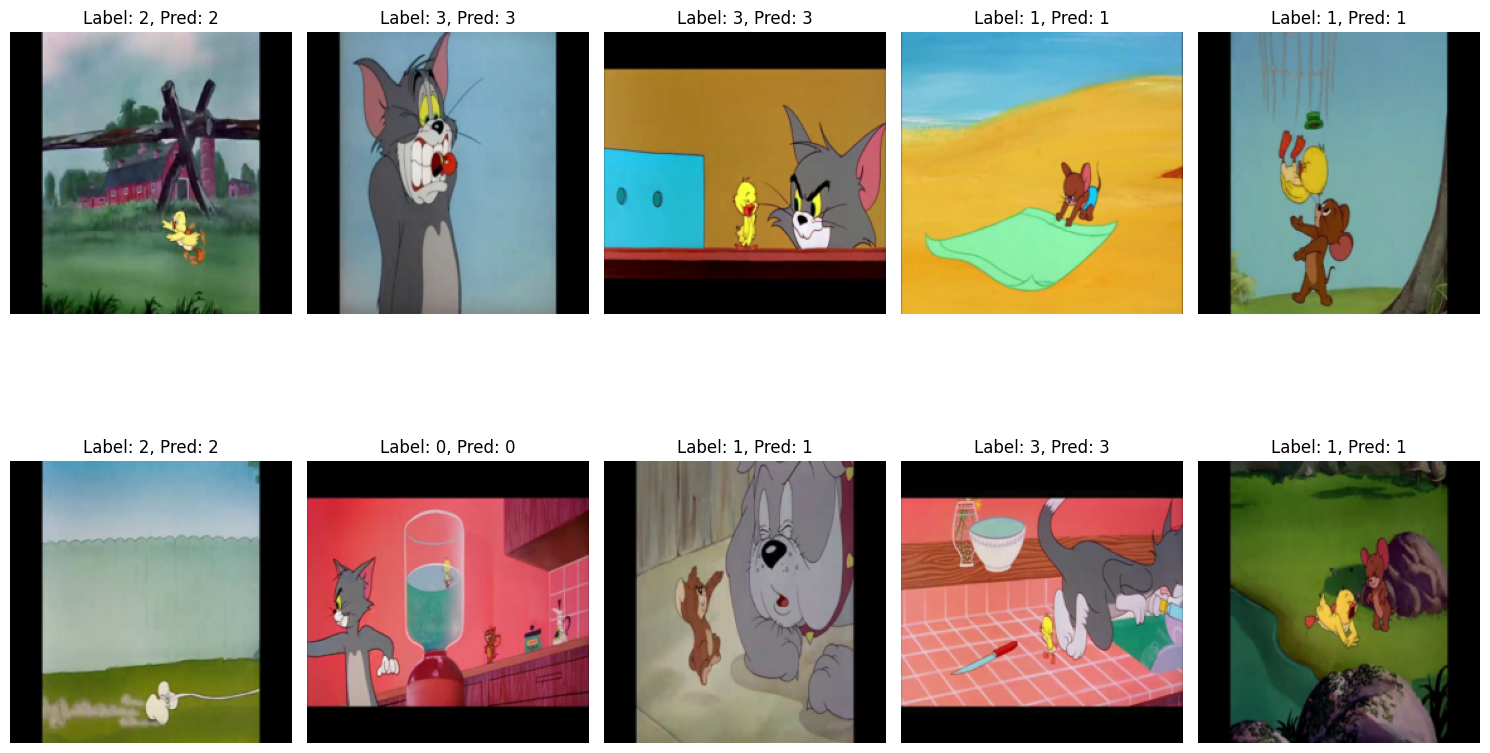

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(2, 5, figsize=(15, 10))
axes = axes.flatten()  # Flatten the 2D array into a 1D array

imgs_indices = [0, 100, 50, 43, 60, 10, 109, 54, 423, 640]
model.eval()
model.to('cpu')

for i in range(10):
    img, label = valid_dataset[imgs_indices[i]]
    with torch.no_grad():
        output = model(img.unsqueeze(0))  # Add batch dimension
        predicted_class = torch.argmax(output, dim=1).item()

    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
    img_np = std * img_np + mean  # Denormalize
    img_np = np.clip(img_np, 0, 1)

    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {int(label)}, Pred: {predicted_class}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [44]:
# Assuming 'model' is your trained model variable
# This saves the entire model to a file.
torch.save(model, 'tom_and_jerry_model.pth')

print("Model saved successfully to tom_and_jerry_model.pth")

Model saved successfully to tom_and_jerry_model.pth


Prediction for: Tom-Jerry-Cartoon-Scene-On-Postcard-Tom.webp
  -> Predicted Class: both
  -> Confidence: 0.9999


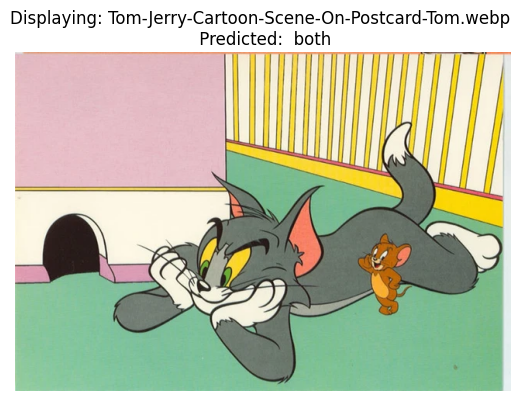

In [53]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

# --- CONFIGURATION BASED ON YOUR NOTEBOOK ---

# 1. CLASS NAMES (extracted directly from your notebook's output)
CLASS_NAMES = ['both', 'jerry', 'neither', 'tom']

# 2. IMAGE TRANSFORMATIONS (using the 'valid' transform from your notebook)
# Note: Using 244x244 as specified in your notebook.
predict_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. SET THE DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_image(model_path, image_path, transform, class_names, device):
    """
    Loads your trained model and predicts the class of a new image.

    Args:
        model_path (str): Path to your saved 'tom_and_jerry_model.pth' file.
        image_path (str): Path to the new image you want to classify.
        transform (transforms.Compose): The preprocessing transformations.
        class_names (list): A list of your class names.
        device (torch.device): The device to run inference on.

    Returns:
        dict: A dictionary containing the predicted class and its confidence score.
    """
    try:
        # Your notebook saved the entire model, so we can load it directly.
        model = torch.load(model_path, map_location=device, weights_only=False)
        model.to(device)
        model.eval()
    except FileNotFoundError:
        return {"error": f"Model file not found at '{model_path}'"}
    except Exception as e:
        return {"error": f"Error loading model: {e}"}

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
    except FileNotFoundError:
        return {"error": f"Image file not found at '{image_path}'"}
    except Exception as e:
        return {"error": f"Error processing image: {e}"}

    with torch.no_grad():
        outputs = model(image_tensor)

        # Since you used CrossEntropyLoss, we use Softmax to get probabilities
        # and find the class with the highest score.
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_index = torch.max(probabilities, 1)

        predicted_class_name = class_names[predicted_index.item()]
        confidence_score = confidence.item()

    result = {
        "predicted_class": predicted_class_name,
        "confidence": f"{confidence_score:.4f}"
    }

    return result

def print_prediction_and_show_image(model_path, image_path, transform, class_names, device):
    """
    NEW FUNCTION: Prints the prediction to the console and separately
    displays the image using imshow.
    """
    # Step 1: Get the prediction result
    prediction = predict_image(model_path, image_path, transform, class_names, device)

    # Step 2: Print the prediction result to the console
    print("-" * 30)
    print(f"Results for: {os.path.basename(image_path)}")
    if "error" in prediction:
        print(prediction["error"])
        return
    else:
        print(f"  -> Predicted Class: {prediction['predicted_class']}")
        print(f"  -> Confidence: {prediction['confidence']}")
    print("-" * 30)

    # Step 3: Display the image in a plot window
    try:
        image = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Displaying: {os.path.basename(image_path)}", fontsize=12) # Simple title
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"\nCould not display image. File not found at: {image_path}")

# --- EXAMPLE USAGE ---

# 1. Set the path to your saved model file
PATH_TO_YOUR_MODEL = '/content/tom_and_jerry_model.pth'

# 2. Set the path to the new image you want to predict
PATH_TO_NEW_IMAGE = '/content/Tom-Jerry-Cartoon-Scene-On-Postcard-Tom.webp' # <--- CHANGE THIS

# --- Run the prediction ---
if __name__ == "__main__":
    if not os.path.exists(PATH_TO_YOUR_MODEL):
        print(f"Error: Model not found at '{PATH_TO_YOUR_MODEL}'")
        print("Please make sure the saved model file is in the same directory or provide the full path.")
    elif not os.path.exists(PATH_TO_NEW_IMAGE):
        print(f"Error: Image not found at '{PATH_TO_NEW_IMAGE}'")
        print("Please update the 'PATH_TO_NEW_IMAGE' variable.")
    else:
        # Get the prediction
        prediction = predict_image(
            model_path=PATH_TO_YOUR_MODEL,
            image_path=PATH_TO_NEW_IMAGE,
            transform=predict_transform,
            class_names=CLASS_NAMES,
            device=DEVICE
        )


        # Print the result
        print(f"Prediction for: {os.path.basename(PATH_TO_NEW_IMAGE)}")
        if "error" in prediction:
            print(prediction["error"])
        else:
            print(f"  -> Predicted Class: {prediction['predicted_class']}")
            print(f"  -> Confidence: {prediction['confidence']}")
        image = Image.open(PATH_TO_NEW_IMAGE)
        plt.imshow(image)
        plt.title(f"Displaying: {os.path.basename(PATH_TO_NEW_IMAGE)} \n Predicted:  {prediction['predicted_class']}", fontsize=12) # Simple title
        plt.axis('off')
        plt.show()
